In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, NMF

plt.style.use('seaborn')

In [2]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [3]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Getting Recommendations

In [4]:
def jaccard_similarity(df):
    return (1 - pairwise_distances(df, metric="jaccard"))


def get_anime_id(search_term):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([search_term])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


def view_title_similarity(search_term, recom_titles):
    for title in recom_titles:
        seq_matcher = SequenceMatcher(None, search_term, title)
        print(f'The terms "{search_term}" and "{title}" are ' 
              + '{0:.2%}'.format(seq_matcher.quick_ratio()) + ' alike.')
        
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title


def get_search_term(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title


def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]

    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)



In [5]:
df_w_rank = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [6]:
cos_sim_rank = cosine_similarity(df_w_rank.values)

## PCA

In [7]:
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


### With a Standard Scaler

In [8]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)
X_standard_scaled

array([[ 1.65266733, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245,  1.92057355,  1.24756653, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [ 1.65266733, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       ...,
       [-0.60508245, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245, -0.52067779,  1.24756653, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499]])

In [9]:
pca_standard_scaled = PCA()
X_pca_standard = pca_standard_scaled.fit_transform(X_standard_scaled)

In [10]:
X_pca_standard.shape

(9832, 265)

In [11]:
pca_standard_scaled.explained_variance_

array([6.15046146, 4.23983686, 3.25032604, 3.17878785, 2.80340468,
       2.63878148, 2.56935227, 2.42191337, 2.28942138, 2.2386518 ,
       2.14109236, 2.03981298, 1.99157931, 1.92171266, 1.8558241 ,
       1.83156818, 1.80293845, 1.7905709 , 1.75904564, 1.71599274,
       1.70058392, 1.66464981, 1.63561664, 1.60017006, 1.59842187,
       1.57165096, 1.55514265, 1.53600649, 1.52019404, 1.51510317,
       1.50416121, 1.48368399, 1.46796179, 1.46255739, 1.44773385,
       1.43431477, 1.4285226 , 1.41371652, 1.40099715, 1.38608501,
       1.38384063, 1.3773595 , 1.36103569, 1.35224197, 1.34737778,
       1.32892634, 1.3212234 , 1.31886795, 1.29550819, 1.28307471,
       1.27756778, 1.27559455, 1.26134026, 1.25565432, 1.24924452,
       1.23543805, 1.23361887, 1.22752247, 1.22194682, 1.21776278,
       1.2065423 , 1.20195508, 1.19360362, 1.18197324, 1.17776643,
       1.17434566, 1.16589606, 1.1593518 , 1.15317569, 1.15116405,
       1.14156839, 1.13875285, 1.13174349, 1.12618269, 1.12025

### Selecting N-Components

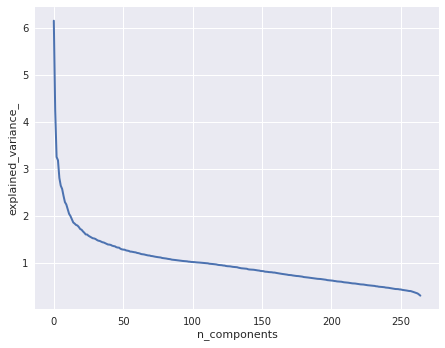

In [12]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_standard_scaled.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

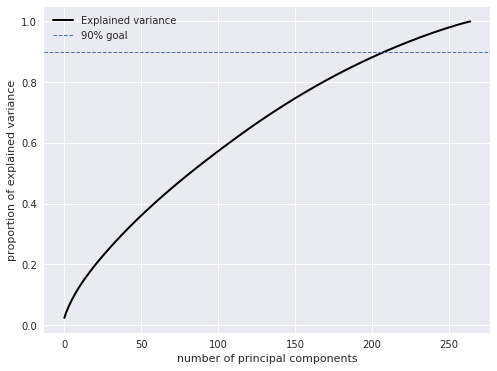

In [13]:
total_variance = np.sum(pca_standard_scaled.explained_variance_)
cum_variance = np.cumsum(pca_standard_scaled.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color = 'black', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=1)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend();

In [14]:
len(prop_var_expl[prop_var_expl <= 0.9])

209

### With a Robust Scaler

In [15]:
X = df_w_rank.to_numpy()

robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)
X_robust_scaled

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
pca_robust_scaled = PCA()
X_pca_robust = pca_robust_scaled.fit_transform(X_robust_scaled)

In [17]:
X_pca_robust.shape

(9832, 265)

In [18]:
pca_robust_scaled.explained_variance_

array([3.17095016e-01, 2.47166905e-01, 2.02863028e-01, 1.91723922e-01,
       1.48433829e-01, 1.17438792e-01, 1.06691972e-01, 9.83114242e-02,
       9.54736507e-02, 7.75808751e-02, 6.40900215e-02, 6.12821139e-02,
       5.64178294e-02, 5.40338440e-02, 5.14370504e-02, 4.03808359e-02,
       3.55294375e-02, 3.53376712e-02, 3.20539640e-02, 3.01383478e-02,
       2.66751161e-02, 2.38998955e-02, 2.35775430e-02, 2.22208530e-02,
       2.19604131e-02, 1.90672938e-02, 1.88779496e-02, 1.78655849e-02,
       1.74777503e-02, 1.55938685e-02, 1.46738465e-02, 1.35896401e-02,
       1.31059423e-02, 1.26822374e-02, 1.25171492e-02, 1.16817410e-02,
       1.12066450e-02, 1.10876007e-02, 1.08835536e-02, 1.05155569e-02,
       1.00501101e-02, 9.74656662e-03, 9.47270837e-03, 9.12001584e-03,
       9.09539553e-03, 8.90343854e-03, 8.72861873e-03, 8.60096311e-03,
       8.27966499e-03, 8.10657515e-03, 7.89897726e-03, 7.73617356e-03,
       7.63102871e-03, 7.57948223e-03, 7.22636500e-03, 7.04736621e-03,
      

### Selecting N-Components

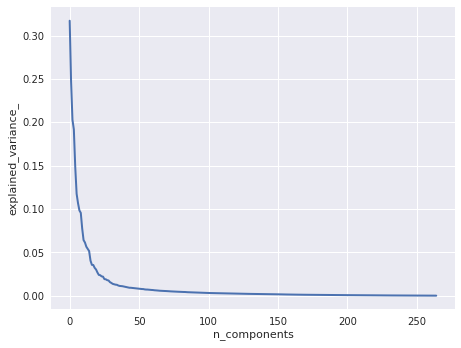

In [19]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_robust_scaled.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

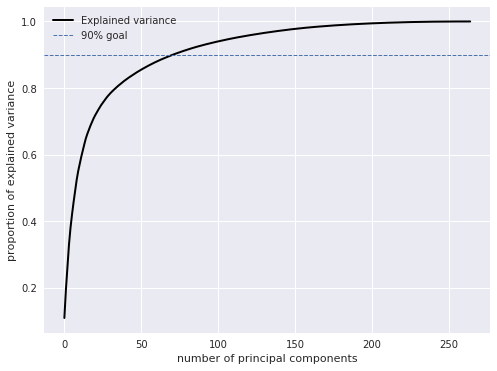

In [20]:
total_variance = np.sum(pca_robust_scaled.explained_variance_)
cum_variance = np.cumsum(pca_robust_scaled.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color = 'black', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=1)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend();

In [21]:
len(prop_var_expl[prop_var_expl <= 0.9])

71

In [33]:
X = df_w_rank.to_numpy()

robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)


robust_pca = PCA(n_components=71)
X_robust_pca_71pc = robust_pca.fit_transform(X_robust_scaled)

In [37]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

standard_pca = PCA(n_components=209)
X_standard_pca_209pc = standard_pca.fit_transform(X_standard_scaled)

### Exploring principal components and features

In [26]:
df_robust_pca_71pc = pd.DataFrame(X_robust_pca_71pc, 
                                index=df_w_rank.index)
df_robust_pca_71pc

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
id,,,,,,,,,,,,,,,,,,,,,
10161,0.902054,-0.308564,0.735503,0.421122,0.017534,0.030490,0.243384,0.231923,-0.359570,0.040511,...,-0.101245,0.050613,0.030588,-0.141243,0.027863,0.076771,-0.058671,-0.271561,0.322695,0.023758
99726,-0.553772,0.919423,-0.563405,0.693138,0.492470,0.506488,0.254710,-0.667565,0.478515,0.084262,...,0.043548,-0.099464,-0.004489,0.277550,0.152170,0.185829,0.495546,0.059917,-0.302376,-0.272596
98526,0.562031,-0.360142,0.285042,0.437012,-0.341345,-0.349306,0.202699,0.012140,-0.634209,-0.074445,...,0.180569,0.034302,-0.010509,0.022931,0.006083,-0.022009,-0.092886,0.031092,-0.166184,-0.045388
966,-0.947915,0.433247,0.318086,-0.000632,-0.138365,-0.067705,0.449668,-0.391173,0.295403,-0.160394,...,-0.153708,-0.162830,0.049283,0.220293,0.455636,-0.182201,-0.142705,-0.127432,-0.049671,-0.041276
4876,0.893532,0.062809,-0.076532,0.672134,0.141467,-0.872544,0.062129,-0.331749,-0.450992,0.038072,...,0.024948,-0.025054,-0.124950,-0.044443,0.034805,0.180647,-0.025998,-0.019572,0.079498,0.159609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,-0.492690,-0.461529,0.077596,0.035290,-0.218350,0.116027,0.676679,-0.626119,0.378083,-0.271106,...,-0.055995,0.041847,0.200533,0.010816,0.046161,0.050165,-0.060543,-0.028804,-0.012146,0.077909
99916,-0.610720,-0.477351,0.175739,0.605864,-0.083200,0.536619,0.216233,-1.029686,0.625074,-0.133925,...,-0.139886,0.121875,-0.080475,0.190566,-0.194751,-0.173844,0.122630,0.106008,-0.069856,0.035161
101283,0.072873,-0.510824,-0.055954,0.054418,-0.351963,-0.368537,-0.174321,0.523298,0.773766,0.113510,...,-0.290177,-0.076269,-0.006739,-0.027407,0.084791,0.061743,0.211649,-0.164593,-0.331326,0.176694


In [27]:
df_standard_pca_209pc = pd.DataFrame(X_standard_pca_209pc, 
                                index=df_w_rank.index)
df_standard_pca_209pc

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
id,,,,,,,,,,,,,,,,,,,,,
10161,3.063571,-1.640470,-0.071279,-2.650845,1.894035,-1.496825,-0.164351,2.119505,-4.137510,0.073708,...,1.085432,1.039557,-4.100998,0.089925,-1.367444,-0.828823,-1.902727,-3.140424,-0.236659,0.851908
99726,4.010917,4.335139,-1.888418,1.029366,-1.874870,-2.467921,-5.641306,-6.291143,-8.640175,5.273623,...,1.764646,3.147692,-0.099970,-1.406968,0.006904,2.291694,4.946525,0.588354,1.142237,-1.839510
98526,-0.183942,-1.841654,-1.664096,-2.010958,-0.621135,-0.506965,0.022174,0.017981,-0.341538,-0.125690,...,0.286754,-0.196256,0.384196,0.055807,-0.449637,1.057647,0.977904,-1.116682,-0.463912,0.520028
966,0.115461,2.901324,0.605235,-0.226751,-1.880438,-0.005181,-0.340976,-0.362809,1.774320,1.447451,...,0.026857,-0.429066,1.538244,-0.208864,1.156193,0.877946,-0.221531,-0.881867,1.585398,0.061354
4876,2.242275,-2.478343,-0.001154,1.095843,-1.187630,4.356415,3.637216,-2.499969,-0.286739,0.824941,...,-0.272486,0.781945,-0.382629,-1.131698,0.983333,-1.435821,-0.104316,0.308948,-0.623524,1.200471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,0.931779,5.407990,-0.433098,-2.080843,0.182005,0.900742,-0.540962,0.908307,1.862650,-0.857104,...,3.434093,-1.010475,-2.042055,0.213802,1.990934,-0.142608,-0.041279,0.270877,-1.660476,2.929538
99916,1.312658,5.252249,-1.832975,-2.461665,1.838247,0.335377,1.147527,0.621676,0.057255,-1.192106,...,-0.612333,-0.020726,-1.316301,-0.962016,-1.570382,-0.543360,-0.074579,-0.838902,0.739490,-0.285910
101283,14.639746,-1.380736,8.207762,-2.389968,6.336184,-7.314752,0.313473,4.416336,5.215144,-0.903680,...,3.232721,-0.454533,-0.126808,0.157380,-0.034848,1.153299,-5.800132,-2.225266,-2.442828,-0.450450


In [28]:
sim_mat_robust_pca = cosine_similarity(df_robust_pca_71pc.values)

In [29]:
sim_mat_standard_pca = cosine_similarity(df_standard_pca_209pc.values)

In [ ]:
def view_features_from_id(_id, _df):
    single_show = _df.loc[_id,:]
    
    return set(single_show[single_show != 0].index)



In [ ]:
def get_common_tags(list_of_ids):
    list_of_tags = [view_features_from_id(_id, df) for _id in list_of_ids]

    return set.intersection(*list_of_tags)

In [34]:
pc_and_features_robust = pd.DataFrame(robust_pca.components_, columns=df_w_rank.columns)
pc_and_features_robust.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
0,0.551024,0.295329,-0.517596,0.071318,-0.052938,0.162764,0.029915,-0.008734,0.196966,-0.049406,...,0.000365,-0.013993,-0.000130,-0.001023,0.000188,-0.000178,0.000001,-0.002353,-0.007175,0.000731
1,0.306863,0.388868,0.716760,-0.171425,0.096076,0.278198,-0.019124,0.013853,0.010930,-0.242654,...,0.004756,0.004234,0.000140,-0.000936,0.000289,0.001020,0.000704,0.003687,0.001929,0.003099
2,0.251196,-0.334803,0.260712,0.158294,0.065612,-0.598823,-0.007525,-0.029574,0.233905,-0.070830,...,-0.008031,0.008998,0.001413,0.001271,-0.000045,0.002690,0.002162,-0.005519,0.010008,0.001131
3,0.024465,0.063969,-0.049918,0.722560,0.029649,0.229211,0.030808,0.023483,-0.084070,-0.143417,...,0.008607,0.015919,-0.000983,0.005745,0.000397,0.001645,0.006535,0.017395,0.018475,0.002666
4,-0.534272,0.563757,0.042343,0.195306,-0.111869,-0.112769,-0.073641,-0.021528,0.167961,0.003171,...,-0.005310,0.002129,-0.001127,0.000318,0.000064,-0.002210,-0.003515,-0.016341,-0.015443,-0.012880


In [35]:
for idx, vec in pc_and_features_robust.iterrows():
    vec_sorted = vec.sort_values(ascending=False)
    print('Principal Component ', idx)
    print(round(vec_sorted[(vec_sorted > 0.10) | (vec_sorted < -0.10)], 2))

    print('--------------------')

Principal Component  0
action           0.55
sci_fi           0.37
adventure        0.30
mecha            0.20
fantasy          0.16
school          -0.10
romance         -0.14
slice_of_life   -0.25
comedy          -0.52
Name: 0, dtype: float64
--------------------
Principal Component  1
comedy       0.72
adventure    0.39
action       0.31
fantasy      0.28
shounen      0.16
drama       -0.17
music       -0.24
Name: 1, dtype: float64
--------------------
Principal Component  2
sci_fi       0.48
comedy       0.26
action       0.25
mecha        0.23
drama        0.16
romance      0.14
adventure   -0.33
fantasy     -0.60
Name: 2, dtype: float64
--------------------
Principal Component  3
drama                 0.72
romance               0.47
fantasy               0.23
slice_of_life         0.17
supernatural          0.15
school                0.12
male_protagonist      0.11
female_protagonist    0.11
music                -0.14
Name: 3, dtype: float64
--------------------
Principal Compone

In [42]:
pp = pprint.PrettyPrinter()
# getting the top titles associated with the first principal components
cut_off = 10
top_n_comps = 50
print(f'Here are the first {top_n_comps} principal components with shows that are good examples and genre/tags that are most common.')
print('--------')
for pc, content in df_robust_pca_71pc.iloc[:,:top_n_comps].items():
    print(f'Principal Component {pc}:')
    top_n_ids = content.sort_values(ascending=False)[:cut_off].index
    pp.pprint([get_title_from_id(_id) for _id in top_n_ids])
    print('-----')

Here are the first 50 principal components with shows that are good examples and genre/tags that are most common.
--------
Principal Component 0:
['Mobile Suit Gundam Wing',
 'Napping Princess',
 'Melody of Oblivion',
 'Mobile Suit Gundam I',
 "Dragon's Heaven",
 'Yamato Takeru',
 'A Wind Named Amnesia',
 'Digimon X-Evolution',
 'Leda: The Fantastic Adventure of Yohko',
 'Yamato Takeru: After War']
-----
Principal Component 1:
['The Seven Deadly Sins',
 'The Familiar of Zero',
 'Dragon Ball Z Movie: Battle of Gods',
 'Fairy Tail Final Season',
 "Dragon Ball Z Movie: Resurrection 'F'",
 'Is It Wrong to Try to Pick Up Girls in a Dungeon?',
 'Fairy Tail (2014)',
 'Dragon Ball Z: Broly - Second Coming',
 'Black Clover',
 'Fairy Tail']
-----
Principal Component 2:
['Gurren Lagann',
 'DARLING in the FRANXX',
 'Infinite Stratos',
 'Infinite Stratos 2',
 'Gunbuster',
 'IS: Infinite Stratos 2 - Hitonatsu no Omoide',
 'Martian Successor Nadesico: The Prince of Darkness',
 'Martian Successor Nade

 'PSYCHO-PASS',
 'Code Geass: Lelouch of the Rebellion R2',
 'Eden of The East',
 'Death Note',
 'Jin-Roh: The Wolf Brigade']
-----
Principal Component 31:
['Cowboy Bebop',
 'Fate/Zero Season 2',
 'Xenosaga: The Animation',
 'Cells at Work!',
 'Active Raid',
 'Baccano!',
 'Interstella 5555: The 5tory of the 5ecret 5tar 5ystem',
 'Gintama',
 'Space Dandy',
 'Planetes']
-----
Principal Component 32:
['Overlord III',
 'Overlord II',
 'Re:ZERO -Starting Life in Another World-',
 'TSUKIPRO THE ANIMATION',
 'Overlord',
 'Vampire Princess Miyu',
 'Dance with Devils',
 'How Not to Summon a Demon Lord',
 'That Time I Got Reincarnated as a Slime',
 'Show By Rock!!']
-----
Principal Component 33:
['Revolutionary Girl Utena',
 'Tower of God',
 'Nichijou - My Ordinary Life',
 'Cromartie High School',
 'Cells at Work!',
 'Flavors of Youth',
 'Flip Flappers',
 'Summer Wars',
 'A Place Further Than the Universe',
 'Ping Pong the Animation']
-----
Principal Component 34:
['MUSHI-SHI',
 'The World God O

In [38]:
pc_and_features_standard = pd.DataFrame(standard_pca.components_, columns=df_w_rank.columns)
pc_and_features_standard.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
0,0.106088,0.021442,-0.009495,0.111158,0.023330,0.034244,0.073276,0.030296,0.015268,-0.057264,...,0.040218,0.053156,-0.005883,0.029291,0.017968,0.051546,0.072173,0.040217,0.069458,0.036504
1,-0.166073,-0.108072,0.168824,-0.010255,0.088132,0.000799,-0.050182,0.098514,-0.168544,0.026605,...,0.045406,0.084210,0.000364,0.056223,-0.011719,0.010513,0.027317,0.047790,0.127882,0.003314
2,-0.116877,-0.086391,-0.002010,-0.012685,-0.035721,-0.091428,0.109140,-0.123110,-0.222663,0.003732,...,-0.056585,0.015042,0.007832,-0.018873,0.001437,0.071863,0.026184,0.026822,-0.095193,0.017031
3,0.112092,0.161707,0.038714,-0.101661,0.087277,0.253452,0.048121,0.080866,-0.132113,-0.101513,...,0.075726,-0.082863,-0.005058,-0.041056,0.032513,-0.026297,0.026450,0.069352,-0.039020,0.042067
4,-0.070866,-0.004653,-0.153806,-0.027373,-0.124502,0.098410,0.033402,0.265655,-0.062852,0.137767,...,0.094015,-0.047964,-0.014489,-0.040083,-0.013876,-0.047119,-0.016223,-0.003639,0.104554,-0.009981


In [39]:
for idx, vec in pc_and_features_standard.iterrows():
    vec_sorted = vec.sort_values(ascending=False)
    print('Principal Component ', idx)
    print(round(vec_sorted[(vec_sorted > 0.10) | (vec_sorted < -0.10)], 2))

    print('--------------------')

Principal Component  0
tragedy                 0.20
male_protagonist        0.18
gore                    0.17
crime                   0.16
anti_hero               0.16
philosophy              0.15
primarily_adult_cast    0.15
psychological           0.15
urban_fantasy           0.15
mystery                 0.14
female_protagonist      0.14
conspiracy              0.14
thriller                0.14
seinen                  0.14
urban                   0.13
revenge                 0.13
memory_manipulation     0.13
guns                    0.11
ensemble_cast           0.11
amnesia                 0.11
supernatural            0.11
drama                   0.11
dystopian               0.11
politics                0.11
action                  0.11
gods                    0.10
body_horror             0.10
Name: 0, dtype: float64
--------------------
Principal Component  1
school                          0.24
primarily_female_cast           0.23
slice_of_life                   0.21
cute_girls_doin

Name: 79, dtype: float64
--------------------
Principal Component  80
triads                0.17
4_koma                0.15
economics             0.15
chibi                 0.15
netorare              0.15
nun                   0.14
outdoor               0.14
work                  0.13
bullying              0.13
yakuza                0.12
rotoscoping           0.12
swimming              0.11
basketball            0.11
classic_literature    0.11
body_swapping         0.10
maids                 0.10
ships                 0.10
age_gap              -0.10
prostitution         -0.10
anthology            -0.10
fishing              -0.11
youkai               -0.11
autobiographical     -0.11
golf                 -0.12
baseball             -0.12
vikings              -0.12
coming_of_age        -0.13
martial_arts         -0.14
incest               -0.15
shogi                -0.17
food                 -0.20
Name: 80, dtype: float64
--------------------
Principal Component  81
full_color        0.23


Name: 159, dtype: float64
--------------------
Principal Component  160
oiran            0.20
teacher          0.17
yakuza           0.16
tokusatsu        0.15
nun              0.14
kids             0.13
witch            0.13
photography      0.13
lacrosse         0.13
cosplay          0.12
mafia            0.12
crossover        0.11
medicine         0.11
kemonomimi       0.10
zombie          -0.10
age_gap         -0.11
vikings         -0.11
slapstick       -0.11
aviation        -0.11
dullahan        -0.11
cult            -0.12
crossdressing   -0.12
super_robot     -0.12
fantasy         -0.13
rural           -0.13
isekai          -0.13
prostitution    -0.14
superhero       -0.22
Name: 160, dtype: float64
--------------------
Principal Component  161
dissociative_identities    0.24
mafia                      0.16
space_opera                0.15
time_manipulation          0.14
primarily_child_cast       0.13
dinosaurs                  0.13
software_development       0.11
martial_arts    

In [41]:
pp = pprint.PrettyPrinter()
# getting the top titles associated with the first principal components
cut_off = 10
top_n_comps = 50
# print(f'Here are the first {top_n_comps} principal components with shows that are good examples and genre/tags that are most common.')
print('--------')
for pc, content in df_standard_pca_209pc.iloc[:,:top_n_comps].items():
    print(f'Principal Component {pc}:')
    top_n_ids = content.sort_values(ascending=False)[:cut_off].index
    pp.pprint([get_title_from_id(_id) for _id in top_n_ids])
    print('-----')

--------
Principal Component 0:
['BANANA FISH',
 'BABYLON',
 'Monster',
 'pet',
 'From the New World',
 'The Future Diary',
 'When They Cry',
 'VINLAND SAGA',
 'One Piece',
 'Serial Experiments Lain']
-----
Principal Component 1:
['Eromanga Sensei',
 'Hugtto! Precure',
 'New Game!',
 'YuruYuri',
 'New Game!!',
 'Ouran High School Host Club',
 'After School Dice Club',
 'Interviews with Monster Girls',
 'Gabriel DropOut',
 'SHIROBAKO']
-----
Principal Component 2:
['Monster',
 'BANANA FISH',
 'Black Lagoon: The Second Barrage',
 'Death Note',
 'BABYLON',
 'Black Lagoon',
 'Akagi',
 'Kaiji - Ultimate Survivor',
 'Darker than Black',
 'The Future Diary']
-----
Principal Component 3:
['Overlord III',
 'GOBLIN SLAYER',
 'Overlord',
 'That Time I Got Reincarnated as a Slime',
 'Overlord II',
 'Is It Wrong to Try to Pick Up Girls in a Dungeon?',
 'Log Horizon',
 'How Not to Summon a Demon Lord',
 'Black Clover',
 'Record of Lodoss War']
-----
Principal Component 4:
['Hugtto! Precure',
 'Symph

In [58]:
search_term = get_search_term('Cowboy Bebop')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

Robust scaler
['Captain Harlock: Arcadia of my Youth',
 'Captain Harlock: Arcadia of my Youth - Endless Orbit SSX',
 'R.O.D -THE TV-',
 'DNA Sights 999.9',
 'Dirty Pair OVA',
 'Marine Express',
 'Outlaw Star',
 'Lupin the 3rd Part IV',
 "Cowboy Bebop: The Movie - Knockin' on Heaven's Door",
 'Trigun']
-----
Standard scaler
['Armored Trooper Votoms',
 'Golgo 13',
 'Sanctuary',
 'Urban Square: Kouhaku no Tsuigeki',
 'Ghost in the Shell',
 'The Big O',
 "Cowboy Bebop: The Movie - Knockin' on Heaven's Door",
 'BANANA FISH',
 'Togainu no Chi',
 'Lupin the Third: The Woman Called Fujiko Mine']


In [59]:
search_term = get_search_term('Dragonball Z')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

Robust scaler
["Dragon Ball Z: Cooler's Revenge",
 'Dragon Ball Z Movie: Return of Cooler',
 'Dragon Ball Z: Super Android 13!',
 "Dragon Ball Z Movie: Resurrection 'F'",
 'Dragon Ball Z Movie: Battle of Gods',
 'Dragon Ball',
 'Dragon Ball Z Kai',
 'Dragon Ball: Yo! Son Goku and His Friends Return!!',
 'Dragon Ball Z Kai: The Final Chapters',
 'Dragon Ball Super']
-----
Standard scaler
['Dragon Ball Z Movie: Return of Cooler',
 'The Boy and The Beast',
 'Wo Jia Da Shixiong Naozi You Keng',
 'My Hero Academia',
 'M3: Sono Kuroki Hagane',
 'Hunter x Hunter',
 'Reikenzan: Hoshikuzu-tachi no Utage',
 'Wo De Tian Jie Nu You',
 'Hunter x Hunter: Greed Island Final',
 'Thunder Prince']


In [60]:
search_term = get_search_term('Attack on Titan')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

Robust scaler
['Attack on Titan: No Regrets',
 'Tower of God',
 'Kabaneri of the Iron Fortress: Light That Gathers',
 'Land of the Lustrous',
 'Attack on Titan: Lost Girls',
 'Attack on Titan OVA',
 'Black Bullet',
 'Attack on Titan Season 3 Part 2',
 'Attack on Titan Season 3',
 'Attack on Titan Season 2']
-----
Standard scaler
['Ttoli Janggun',
 'Joker Game: Kuroneko Yoru no Bouken',
 'Princess Principal: Ange Report',
 'High School Agent',
 'Joker Game',
 'Licensed by Royalty',
 'Crayon Shin-chan Movie 19: Arashi wo Yobu Ougon no Spy Daisakusen',
 'Dr. STONE',
 'Attack on Titan Season 3 Part 2',
 'Attack on Titan Season 2']


The standard scaler does a better job at giving a range of recommended titles but it feels like it sometimes it misses the mark. (I'm surprised a Shin-chan movie was recommended based on "Attack on Titan")  
Also, the robust scaler enabled PCA to get down to a lot less principal components than the standard scaler. 

## NMF

In [68]:
M = df_w_rank
M

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
99916,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
101283,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [76]:
nmf = NMF(n_components=10)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_
nmf.reconstruction_err_

114.38769600121289

In [73]:
W.shape

(9832, 5)

In [74]:
H.shape

(5, 265)

Text(0, 0.5, 'Reconstruction Errror')

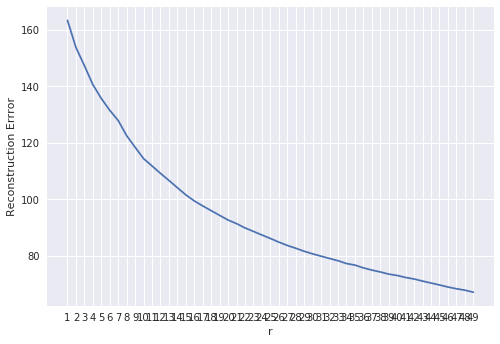

In [90]:
def fit_nmf(r):
    nmf = NMF(n_components=r, 
              init='nndsvd', 
              alpha=1)
    nmf.fit(M)
    W = nmf.transform(M)
    H = nmf.components_
    return nmf.reconstruction_err_

_range = 50
error = [fit_nmf(i) for i in range(1,_range)]
plt.plot(range(1,_range), error)
plt.xticks(range(1, _range))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [118]:
# reconstruction error for 20 compenents
fit_nmf(50)

66.71026499302872

In [129]:
nmf = NMF(n_components=20)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

In [130]:
df_topics_to_item = pd.DataFrame(W, index=df_w_rank.index)
df_topics_to_item

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
10161,0.094068,0.000005,0.119864,0.000000,0.000000,0.098031,0.000735,0.006713,0.000000,0.000685,0.000000,0.000000,0.000000,0.000000,0.000000,0.001069,0.001878,0.000000,0.011246,0.027868
99726,0.000122,0.151933,0.000000,0.127127,0.147764,0.001699,0.132960,0.108135,0.000000,0.000000,0.072983,0.000000,0.000000,0.000000,0.006576,0.000000,0.000000,0.016189,0.000364,0.000000
98526,0.094027,0.000032,0.117927,0.000000,0.000000,0.001665,0.000000,0.000000,0.000000,0.000701,0.000000,0.000000,0.000012,0.012312,0.000000,0.000141,0.000000,0.000000,0.000000,0.000000
966,0.000000,0.150754,0.000000,0.001525,0.003652,0.000000,0.140299,0.000000,0.000000,0.001050,0.000000,0.081985,0.141825,0.000000,0.000000,0.000000,0.111687,0.097344,0.000000,0.000000
4876,0.093945,0.000000,0.124469,0.000000,0.151544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136068,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136573,0.000000,0.000000,0.000687,0.159383,0.000000,0.146117,0.000000,0.000000,0.170331,0.000000,0.000000,0.000000,0.000000
99916,0.000000,0.000000,0.000620,0.000000,0.000000,0.000000,0.133075,0.106263,0.000000,0.000000,0.135328,0.000000,0.000000,0.000000,0.000000,0.000000,0.140418,0.000000,0.000000,0.000000
101283,0.003190,0.000000,0.000000,0.000000,0.000000,0.001611,0.000000,0.000209,0.015104,0.000000,0.067808,0.011520,0.000000,0.001197,0.186343,0.000000,0.000000,0.013806,0.285245,0.003787


In [131]:
df_topics_to_features = pd.DataFrame(H, columns=df_w_rank.columns)
df_topics_to_features

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
0,10.546585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.003991,0.000000,0.000000,0.004024,0.000000,0.000000,0.004230,0.019370
1,0.000000,0.000000,6.753385,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.030398,0.000327,0.000000,0.000000,0.007278,0.000000,0.000000,0.000000,0.006090
2,0.000000,0.000000,0.000000,8.413965,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.001405,0.002975,0.000000,0.021182,0.000000,0.000000,0.000491,0.002709,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,7.893835,0.000000,0.00000,0.000000,0.000000,...,0.023129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051151,0.000000,0.000000
4,0.000000,6.736908,0.000000,0.000000,0.000000,0.000000,0.002770,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002977,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.005071,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.005019,0.000000,0.000000,0.000502,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.220227,0.000000,0.014416,0.000000,0.000000,0.000000,0.058668,0.000000,0.000000
7,0.000000,0.000000,0.026352,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.036015,0.000000,0.000000,0.034489,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.353925,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000214,0.006495,0.009760,0.329244,0.000000,0.096642
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01655,0.000000,5.286975,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000346,0.000000,0.000000,0.003289


In [132]:
for topic in df_topics_to_item.items():
    print('Topic ', topic[0])
    for _id in list(topic[1].sort_values(ascending=False)[:5].index):
        print(get_title_from_id(_id))
    print('-----')

Topic  0
Hellsing
Brave 10
K: SEVEN STORIES "SIDE:BLUE - Sirius - "
Attack on Titan Season 3
K
-----
Topic  1
Pop Team Epic
Quack Experimental Anime Excel Saga
Gintama
Cromartie High School
Sayonara Zetsubou Sensei
-----
Topic  2
Rose of Versailles
VINLAND SAGA
Fullmetal Alchemist
In This Corner of the World
Fullmetal Alchemist: Brotherhood
-----
Topic  3
Overlord III
That Time I Got Reincarnated as a Slime
Overlord
InuYasha
How Not to Summon a Demon Lord
-----
Topic  4
Famous Dog Lassie
Magic Tree House
Dinosaur King D-Kids Adventure: Pterosaur Legend
Nadia: The Secret of Blue Water
Chiisana Viking Vickie
-----
Topic  5
Xenosaga: The Animation
Star Blazers 2199
Space Dandy
DARLING in the FRANXX
Galaxy Fraulein Yuna Returns
-----
Topic  6
Non Non Biyori: Repeat - Hotaru ga Tanoshinda
Laid-Back Camp
K-ON! Season 2
K-ON!
KONOHANA KITAN
-----
Topic  7
Itazura na Kiss
Nana
Kimi ni Todoke: From Me to You
Nisekoi
Sequence
-----
Topic  8
Beyond the Boundary
Beyond the Boundary -I'LL BE HERE-:

In [134]:
for topic in df_topics_to_features.iterrows():
    print('Topic', topic[0])
    print(topic[1].sort_values(ascending=False)[:5])
    print('-----')

Topic 0
action         10.546585
super_power     0.660013
swordplay       0.274986
guns            0.213003
military        0.189116
Name: 0, dtype: float64
-----
Topic 1
comedy            6.753385
parody            0.356022
kids              0.174699
surreal_comedy    0.121343
meta              0.079508
Name: 1, dtype: float64
-----
Topic 2
drama            8.413965
historical       0.537215
tragedy          0.446583
military         0.270110
coming_of_age    0.242976
Name: 2, dtype: float64
-----
Topic 3
fantasy    7.893835
magic      0.396884
isekai     0.273592
demons     0.254104
kids       0.233500
Name: 3, dtype: float64
-----
Topic 4
adventure     6.736908
kids          0.276234
historical    0.159975
animals       0.139745
isekai        0.124239
Name: 4, dtype: float64
-----
Topic 5
sci_fi              10.370421
space                0.830372
aliens               0.647435
robots               0.375515
post_apocalyptic     0.327511
Name: 5, dtype: float64
-----
Topic 6
slice_of_

In [136]:
M.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [135]:
df_topics_to_item.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
10161,0.094068,0.000005,0.119864,0.000000,0.000000,0.098031,0.000735,0.006713,0.0,0.000685,0.000000,0.000000,0.000000,0.000000,0.000000,0.001069,0.001878,0.000000,0.011246,0.027868
99726,0.000122,0.151933,0.000000,0.127127,0.147764,0.001699,0.132960,0.108135,0.0,0.000000,0.072983,0.000000,0.000000,0.000000,0.006576,0.000000,0.000000,0.016189,0.000364,0.000000
98526,0.094027,0.000032,0.117927,0.000000,0.000000,0.001665,0.000000,0.000000,0.0,0.000701,0.000000,0.000000,0.000012,0.012312,0.000000,0.000141,0.000000,0.000000,0.000000,0.000000
966,0.000000,0.150754,0.000000,0.001525,0.003652,0.000000,0.140299,0.000000,0.0,0.001050,0.000000,0.081985,0.141825,0.000000,0.000000,0.000000,0.111687,0.097344,0.000000,0.000000
4876,0.093945,0.000000,0.124469,0.000000,0.151544,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136068,0.000000,0.000000


## Comparing Everything

In [155]:
nmf = NMF(n_components=50)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

In [146]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

standard_pca = PCA(n_components=50)
X_standard_pca_50pc = standard_pca.fit_transform(X_standard_scaled)

In [151]:
df_standard_pca_50pc = pd.DataFrame(X_standard_pca_50pc, 
                                index=df_w_rank.index)

In [170]:
sim_mat_standard_pca_50pc = cosine_similarity(X_standard_pca_50pc)

In [158]:
sim_mat_nmf_50comps = cosine_similarity(W)

In [164]:
df_w_rank

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
99916,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
101283,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [ ]:
cos_sim_no_reduc = cosine_similarity(df_w_rank.values)

In [171]:
sim_mat_standard_pca_209pc = cosine_similarity(df_standard_pca_209pc.values)

In [175]:
def compare_dim_reducs(anime_title):
    search_term = get_search_term(anime_title)
    id_list = get_anime_id(search_term)
    nmf_rec_list = get_top_n_recommendations(id_list, 
                                         pd.DataFrame(W, index=df_w_rank.index), 
                                         sim_mat_nmf_50comps, 
                                         n=10)
    ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                         df_standard_pca_50pc, 
                                         sim_mat_standard_pca_50pc, 
                                         n=10)
    ss_pca_209pc_rec_list = get_top_n_recommendations(id_list, 
                                         df_standard_pca_209pc, 
                                         sim_mat_standard_pca_209pc, 
                                         n=10)
    rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                         df_robust_pca_71pc, 
                                         sim_mat_robust_pca, 
                                         n=10)
    basic_rec_list = get_top_n_recommendations(id_list, 
                                         df_w_rank, 
                                         cos_sim_no_reduc, 
                                         n=10)
    print('NMF w/ 50 components')
    pp.pprint(nmf_rec_list)
    print('-----')
    print('PCA w/ 50 PCs')
    pp.pprint(ss_pca_rec_list)
    print('-----')
    print('PCA w/ 209 PCs')
    pp.pprint(ss_pca_209pc_rec_list)
    print('-----')
    print('PCA w/ a Robust Scaler and 71 PCs')
    pp.pprint(rs_pca_rec_list)
    print('-----')
    print('No Dimensionality Reduction')
    pp.pprint(basic_rec_list)

In [176]:
compare_dim_reducs('Dragonball Z')

NMF w/ 50 components
['Dragon Ball Z Movie: Battle of Gods',
 'Dragon Ball Z: Super Android 13!',
 'Toriko: Jump Super Anime Tour 2009 Special',
 "Dragon Ball GT: A Hero's Legacy",
 'Dragon Ball: Episode of Bardock',
 'Dragon Ball Z Kai: The Final Chapters',
 'Dragon Ball: Yo! Son Goku and His Friends Return!!',
 'Dragon Ball Z Kai',
 'Dragon Ball Super',
 'Dragon Ball']
-----
PCA w/ 50 PCs
['Hunter x Hunter',
 'Hunter x Hunter: Greed Island Final',
 'Dragon Ball Z Movie: Return of Cooler',
 'Dragon Ball Z: Wrath of the Dragon',
 'Dragon Ball: Yo! Son Goku and His Friends Return!!',
 "Dragon Ball Z: Cooler's Revenge",
 'Dragon Ball Z: Bojack Unbound',
 'My Hero Academia Season 3',
 'Thunder Prince',
 'My Hero Academia']
-----
PCA w/ 209 PCs
['Dragon Ball Z Movie: Return of Cooler',
 'The Boy and The Beast',
 'Wo Jia Da Shixiong Naozi You Keng',
 'My Hero Academia',
 'M3: Sono Kuroki Hagane',
 'Hunter x Hunter',
 'Reikenzan: Hoshikuzu-tachi no Utage',
 'Wo De Tian Jie Nu You',
 'Hunter 

In [177]:
compare_dim_reducs('Ergo Proxy')

NMF w/ 50 components
['Zegapain',
 'Blue Remains',
 'DARLING in the FRANXX',
 'Neon Genesis Evangelion',
 'Garakowa -Restore the World-',
 'Mardock Scramble: The Third Exhaust',
 'Texhnolyze',
 'Expelled From Paradise',
 'kemurikusa.',
 'Casshern Sins']
-----
PCA w/ 50 PCs
['Ghost in the Shell: Arise - Border:4 Ghost Stands Alone',
 'Ghost in the Shell: Arise - Border:3 Ghost Tears',
 'Ghost in the Shell: Arise - Border:2 Ghost Whispers',
 'Ghost in the Shell: Arise - Border:1 Ghost Pain',
 'Blade Runner: Black Out 2022',
 'Ghost in the Shell: Stand Alone Complex',
 'Texhnolyze',
 'Ghost in the Shell: Stand Alone Complex 2nd GIG',
 'Casshern Sins',
 'Harmony']
-----
PCA w/ 209 PCs
['Ghost in the Shell: Stand Alone Complex - The Laughing Man',
 'Harmony',
 'Garakowa -Restore the World-',
 'Ghost in the Shell: SAC_2045',
 'Grey: Digital Target',
 'Ghost in the Shell: Stand Alone Complex',
 'Battle Angel Alita',
 'Ghost in the Shell: Stand Alone Complex 2nd GIG',
 'Texhnolyze',
 'Casshern

In [181]:
compare_dim_reducs('Gangsta')

NMF w/ 50 components
['Hinomaru Tarou: Musha Shugyou no Maki',
 'Intrigue in the Bakumatsu: Irohanihoheto',
 'Issunboushi: Chibisuke Monogatari',
 'Kangetsu Ittou: Akuryou Kiri',
 'Afro Samurai Pilot',
 'GO! SAMURAI',
 'Shinshuu Sudama-hen',
 'Gifuu Doudou!!: Kanetsugu to Keiji',
 'Lupin the IIIrd: The Blood Spray of Goemon Ishikawa',
 'Shigurui: Death Frenzy']
-----
PCA w/ 50 PCs
['HiGH&LOW g-sword',
 'K: SEVEN STORIES "SIDE:BLUE - Sirius - "',
 'Black Lagoon: The Second Barrage',
 'Koiko no Mainichi',
 'Aachi wa Ssipak',
 '91 Days',
 'Baccano! Specials',
 "Black Lagoon: Roberta's Blood Trail",
 'Gungrave',
 'K: Missing Kings']
-----
PCA w/ 209 PCs
['K: SEVEN STORIES "Circle Vision - Nameless Song - "',
 'K: SEVEN STORIES "R:B - BLAZE -"',
 'HiGH&LOW g-sword',
 "Black Lagoon: Roberta's Blood Trail",
 'K: SEVEN STORIES "Lost Small World - Outside the Cage - "',
 'K: SEVEN STORIES "Memory of RED - BURN -"',
 'K: Return Of Kings',
 'K: SEVEN STORIES "SIDE:GREEN - Overwrite World - "',
 '

In [182]:
compare_dim_reducs('Tokyo Ghoul')

NMF w/ 50 components
['Hell Girl',
 'Hell Girl: Fourth Twilight',
 'The Devil Lady',
 'Devilman Crybaby',
 'Boogiepop Phantom',
 'Ghost Hound',
 'Tokyo Ghoul Root A',
 'Petshop of Horrors',
 'Kizumonogatari Part 3: Reiketsu',
 'Tokyo Ghoul:re']
-----
PCA w/ 50 PCs
["xxxHOLiC - A Midsummer Night's Dream",
 'Seoul Station',
 'Tokyo Ghoul Root A',
 'Alice in Borderland',
 'The Future Diary',
 'King of Thorn',
 'the Garden of sinners Chapter 5: Paradox Paradigm',
 'the Garden of sinners Chapter 1: Thanatos. (Overlooking View)',
 'Another',
 'Ga-Rei-Zero']
-----
PCA w/ 209 PCs
['King of Thorn',
 'Kizumonogatari Part 3: Reiketsu',
 "King's Game",
 'Tokyo Ghoul Root A',
 'Terra Formars',
 'The Future Diary',
 'Another',
 'Alice in Borderland',
 'INUYASHIKI LAST HERO',
 'Asura']
-----
PCA w/ a Robust Scaler and 71 PCs
['Petshop of Horrors',
 'Boogiepop Phantom',
 'Umineko: When They Cry',
 'Kizumonogatari Part 2: Nekketsu',
 'the Garden of sinners Chapter 1: Thanatos. (Overlooking View)',
 'Th

In [183]:
compare_dim_reducs('Food Wars!')

NMF w/ 50 components
['Fafner: Dead Agressor: Heaven and Earth',
 'Fist of the North Star Movie',
 'Plunderer',
 'Now and Then, Here and There',
 "Dragon's Heaven",
 'Utawarerumono OVA',
 'Nausicaä of the Valley of the Wind',
 'Dr. STONE',
 'Desert Punk',
 'Last Exile']
-----
PCA w/ 50 PCs
['Infinite Ryvius',
 "Wolf's Rain",
 'Chrome Shelled Regios',
 'LAST HOPE',
 'Attack on Titan',
 'Jyu-Oh-Sei: Planet of the Beast King',
 'Desert Punk',
 'Mujin Wakusei Survive',
 '7SEEDS Part 2',
 'Dr. STONE']
-----
PCA w/ 209 PCs
['7SEEDS Part 2',
 'Mujin Wakusei Survive',
 'Dragon Ball Specials',
 'Preventing Tuberculosis',
 'Kappa no Kaikata',
 'Rocket Girls',
 'Once Upon a Time... Life',
 'Gijinka de Manabo!',
 'Desert Punk',
 'Dr. STONE']
-----
PCA w/ a Robust Scaler and 71 PCs
['Medabots',
 'Cleopatra D.C.',
 'Saber Marionette J to X',
 'Eon Kid',
 'The Third: The Girl with the Blue Eye',
 'Dokkoida?!',
 'Bomberman Jetters',
 'Last Exile',
 'Desert Punk',
 'Dr. STONE']
-----
No Dimensionality 

In [184]:
compare_dim_reducs('One Punch Man')

NMF w/ 50 components
['Ultraman Graffiti',
 'Eagle Talon',
 'The Super Milk-Chan Show',
 'Carnival Phantasm',
 'Tentai Senshi Sunred',
 'One Punch Man 2 Specials',
 'Time Bokan: Royal Revival',
 'One Punch Man: Road to Hero',
 'One-Punch Man Season 2',
 'One-Punch Man Specials']
-----
PCA w/ 50 PCs
['Disk Wars: Avengers',
 'Gekijouban Infini-T Force: Gatchaman - Saraba Tomo yo',
 'Time Bokan 24',
 'Samurai Flamenco',
 'Time Bokan Series: Zenderman',
 'My Hero Academia OVA',
 'Tentai Senshi Sunred',
 'One Punch Man 2 Specials',
 'One-Punch Man Specials',
 'One-Punch Man Season 2']
-----
PCA w/ 209 PCs
["Time Bokan: The Villains' Strike Back",
 'Warui no wo Taose!! Salaryman Man',
 'Time Bokan Series: Zenderman',
 'Marvel Future Avengers',
 'Disk Wars: Avengers',
 'My Hero Academia OVA',
 'One-Punch Man Season 2',
 'Tentai Senshi Sunred',
 'One-Punch Man Specials',
 'One Punch Man 2 Specials']
-----
PCA w/ a Robust Scaler and 71 PCs
['Bungo Stray Dogs',
 'Bungo Stray Dogs 2 Episode 25 - 

<b> Choosing whether to use dimensionality reduction, and then choosing the best technique is proving difficult. The results from all are subjective and usually very similar. Using PCA w/ 209 principal components might be in the lead because it usually is able to provide a variety of recommendations (but sometimes it fails). And if I'm only cutting down my dimensions by 20%, then is it really worth it?  </b>

<b>After further thought, maybe no dimensionality reduction is the way to go for now. A loss in computation speed is not a big deal for this application at this point. It's more valuable to give more accurate recommendations. </b>